# Interpolation of precipitation extreme characteristics on a large domain toward IDF curve construction at unmonitored locations using RDRS v2.1 as the spatial covariate

Gabriel Gobeil$^{1,2}$, Jonathan Jalbert$^1$ and Luc Perreault$^3$

$^1$Polytechnique Montréal  
$^2$Environment and Climate Change Canada  
$^3$Institut de recherche d'Hydro-Québec  

April 17, 2023


This program goes along with the paper of Jalbert *et al.* (2022) which describes how extreme precipitation of several durations can be interpolated to compute IDF curves on a large, sparse domain. In this code, sparse extreme precipitation characterisitcs for a given duration are interpolated on a regular lattice. The lattice is the one where the spatial covariate lies.

This version uses the hourly reanalyzed precipitations from the Regional Deterministic Reforecast System (Gasset *et al.*, 20) as the spatial covariate.

Jalbert J., Genest, C. and Perreault L., (2022). Interpolation of precipitation extremes on a large domain toward IDF curve construction at unmonitored locations. *Journal of Agricultural, Biological, and Environmental Statistics*, 27:461-486. https://link.springer.com/article/10.1007/s13253-022-00491-5

Gasset, N., Fortin, V., Dimitrijevic, M., Carrera, M., Bilodeau, B., Muncaster, R., Gaborit, É., Roy, G., Pentcheva, N., Bulat, M., Wang, X., Pavlovic, R., Lespinas, F., Khedhaouiria, D. and Mai, J., (2021). A 10 km North American precipitation and land-surface reanalysis based on the GEM atmospheric model. *Hydrology and Earth System Sciences*, 25(9):4917-4945. https://hess.copernicus.org/articles/25/4917/2021/.


In [1]:
using LinearAlgebra, SparseArrays, StatsBase
using Distributions
using CSV, DataFrames
using Gadfly
using ProgressMeter

using Extremes, GMRF, MambaLite
using InterpolationIDF

In [2]:
# Execute if the unregistered packages GMRF and InterpolationIDF are not installed.

# import Pkg
# Pkg.add(url="https://github.com/jojal5/GMRF.jl")
# Pkg.add(url="https://github.com/JuliaExtremes/InterpolationIDF.jl")

In [3]:
# Optimize linear algebra when using Intel processors

using MKL
BLAS.get_config()

LinearAlgebra.BLAS.LBTConfig
Libraries: 
├ [ILP64] libmkl_rt.2.dylib└ [ LP64] libmkl_rt.2.dylib

---
## 0. Configuration

In [4]:
DURATION = "24 h"
#DURATION = "30 min"
PROVINCES = ["NB", "NL", "NS", "ON", "PE", "QC"]

ORDER = 1

NITER = 215000
WARMUP = 15000
THIN = 20

# NITER = 215
# WARMUP = 15
# THIN = 20

# If you want to change the defaut values of the
#STEPSIZE = Dict(:u => .1, :v => .15, :ξ => .02) # Par défaut dans la fonction mcmc

20

---
## 1. Préparation des données

### 1.1. Covariable sur la grille

Comme covariable sur grille, on charge la précipitation journalière moyenne du modèle (P) pour les 78 474 points de grille.

# 1. Data loading and preparation

The covariate are available on a regular lattice covering the northeastern part of North America through 90,000 grid cells. After croping the grid to a domain centered on Eastern Canada (48,694 grid cells), the available weather stations (at most 329 depending on the precipitation duration) are loaded and located on the corresponding grid cells. 

The steps of data preparation are as follows:
1. Loading the gridded spatial covariate.
2. Loading the station list where the IDF curves are available in Canada.
3. Organizing the data in a DataFrame.
4. Selecting the station if more than one lie in the same grid cell.

## 1.1 Loading the gridded spatial covariate

The precipitation from RDRS v2.1 are loaded for the 78 474 cells in a rectangular grid of 319 x 246 centered in Eastern Canada.


In [5]:
griddedCovariate = CSV.read("Data/RDRSmeanPcp.csv", DataFrame)
first(griddedCovariate,5)

5×3 DataFrame
 Row │ Lat      Lon       pr      
     │ Float64  Float64   Float64 
─────┼────────────────────────────
   1 │ 41.7333  -94.9827  3.21852
   2 │ 41.7366  -94.8671  3.2121
   3 │ 41.7398  -94.7515  3.19938
   4 │ 41.7429  -94.6359  3.20216
   5 │ 41.7458  -94.5203  3.23512

In [6]:
m₁, m₂ = 319, 246
m = m₁*m₂

lat = reshape(griddedCovariate[:,1], m₁, m₂)
lon = reshape(griddedCovariate[:,2], m₁, m₂)
pr = reshape(griddedCovariate[:,3], m₁, m₂);

## 1.2 Loading the station list where the IDF curves are available in Canada

Only the stations located in the set PROVINCES are retained.

In [7]:
# Load the list of sations in Canada
station_list = CSV.read(joinpath("Data","_station_list.csv"), copycols=true, DataFrame)

# Selection the stations inside the spatial domain
filter!(row -> row[:Province] ∈ PROVINCES, station_list)

# Coordinates of stations and grid cells
stationLocation = collect([station_list[:,:Lat] station_list[:,:Lon]]')
gridCoords = collect([griddedCovariate[:,:Lat] griddedCovariate[:,:Lon]]')

# Find the grid point associated with each station
V = nnsearch(gridCoords,stationLocation)  

# Add a column corresponding to the index of the grid cell where the station is located.
station_list[!, :GridCell] = V;

## 1.3 Organizing the data in a DataFrame

In [8]:
data = DataFrame(Duration = String[], 
                 Pcp = Float64[], 
                 Year = Int64[], 
                 StationID = String[], 
                 StationName = String[]);


for i = 1:length(station_list[:,:ID])
#     df = idf_load(station_list[i,:ID], "../../0-Données/stations/")    # Fonction idf_load()
    df = idf_load(station_list[i,:ID], "data/")    # Fonction idf_load()
    df[!,:StationID] .= station_list[i,:ID]
    df[!,:StationName] .= station_list[i,:Name]
    append!(data,df)
end

# Duration selection
filter!(row -> row[:Duration] == DURATION, data)

# List of active stations
activeStation = unique(data[:,:StationID])

# Selection of active stations only :
filter!(row -> row[:ID] ∈ activeStation, station_list) 

Y = Vector{Float64}[]
for stationID in station_list[:, :ID]
    y = data[data[:, :StationID] .== stationID, :Pcp]
    push!(Y,y)
end
station_list.Data = Y;

## 1.4 Selecting the station if more than one lie in the same grid cell

If more than one station lie in the same grid cell, keeping the one with the longest period of record.

In [9]:
# Liste des stations à garder pour éviter d'en avoir plus qu'une par cellule :
stationID = String[]
for v in unique(station_list.GridCell)  # pour chacune des 133 cellules uniques,
    
    ind = findall(v .== station_list.GridCell)  # on récupere les indices des stations sur ces grilles
    if length(ind) == 1
        push!(stationID, station_list[ind[1], :ID])  # s'il n'y en a qu'une seule, on la push!
    else
        n = Int64[]
        for i = 1:length(ind)
            push!(n, length(station_list[ind[i], :Data]))  # sinon, on compte le nombre de données
        end
        pos = argmax(n)
        push!(stationID, station_list[ind[pos],:ID])
    end
end
filter!(row -> row[:ID] ∈ stationID, station_list)

sort!(station_list, :GridCell)

first(station_list, 5)

5×8 DataFrame
 Row │ Name                Province  ID       Lat      Lon      Elevation  Gri ⋯
     │ String              String3   String7  Float64  Float64  Int64      Int ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ POINT PELEE CS      ON        613P001    41.95   -82.52        176      ⋯
   2 │ HARROW CDA AUTO     ON        6133362    42.03   -82.9         191
   3 │ WINDSOR UNIVERSITY  ON        6139538    42.3    -83.07        179
   4 │ WINDSOR A           ON        6139525    42.28   -82.97        189
   5 │ CHATHAM WPCP        ON        6131415    42.38   -82.22        180      ⋯
                                                               2 columns omitted

---
# 2. Latent iGMRF definition

The grid structure for the latent iGMRFs is defined. The set of grid cells where the observations are defined in $S$ is defined and the remaining grid cells are defined in $\bar{S}$. Conditional independant subsets are also defined to improve mcmc performance.

In [10]:
@time G = GMRF.iGMRF(m₁,m₂,1,1).G

 68.342379 seconds (6.46 M allocations: 46.249 GiB, 0.18% gc time, 2.45% compilation time)


GridStructure
gridSize :	(319, 246)
nbs :		Vector{Vector{Int64}}[78474]


In [11]:
# Create the datastructure using the average daily precipitation from RDRS v2.1 and the station elevation
# as the spatial covariates

@time datastructure = create_datastructure(G, station_list, m₁, m₂, 
    log.(griddedCovariate[:,:pr]), Float64.(station_list.Elevation))

  0.408010 seconds (680.72 k allocations: 49.039 MiB, 95.00% compilation time)


DataStructure
Y :		Vector{Vector{Float64}}[318]
X₁ᵢ :		Matrix{Float64}[(318, 2)]
X₂ᵢ :		Matrix{Float64}[(318, 2)]
G :
	GridStructure
	gridSize :	(319, 246)
	nbs :		Vector{Vector{Int64}}[78474]

S :
	GridPointStructure
	V :		Vector{Int64}[318]
	CondIndSubset :		Vector{Vector{Int64}}[2]
	CondIndIndex :		Vector{Vector{Int64}}[2]

S̄ :
	GridPointStructure
	V :		Vector{Int64}[78156]
	CondIndSubset :		Vector{Vector{Int64}}[2]
	CondIndIndex :		Vector{Vector{Int64}}[2]


In [12]:
# Find the index of the Montréal-Trudeau airport station
ind = findfirst(station_list.ID .== "702S006")

118

---
# 3. Markov Chain Monte Carlo for parameter estimation

Markov Chain Monte Carlo procedure to generate a random sample of the posterior distribution. Note that only the parameter values at the grid cells containing observations are retained to save memory. The values at the remaining grid cells can be interpolated offline.

In [13]:
# Sans valeurs initiales en entrée :
C = mcmc(datastructure, niter=NITER, warmup=WARMUP, thin=THIN) 

#  # Retourne U et V de la dernière itération :
# # C, U, V = mcmc(datastructure, niter=NITER, warmup=0, thin=1, returnUV=false) 
# C = mcmc(datastructure, niter=NITER, warmup=WARMUP, thin=THIN) 

Progress: 100%|█████████████████████████████████████████| Time: 2:33:10


Object of type "Chains"

Iterations = 15001:214981
Thinning interval = 20
Chains = 1
Samples per chain = 10000

[3.125547717394715 3.102360219210282 … -0.00041762234965347705 0.0828440399490202; 3.079137736272361 3.2078957585740744 … -0.0003827060947387178 0.08623286701908199; … ; 3.0521018259974904 3.1108994970372437 … -0.00020674519026062487 0.09007784810028865; 3.1208080774897593 3.1449549448132412 … -9.715073244380247e-5 0.07215189367617895;;;]

### Acceptation rate for some parameters

It should be computed before or without thinning.

In [14]:
# MambaLite.changerate(C[:, "u[ind]", 1])

### Trace plots for some parameters

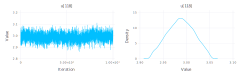

In [15]:
trace_plot(getindex(C, :, "u[$ind]", :))

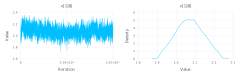

In [16]:
trace_plot(getindex(C, :, "v[$ind]", :))

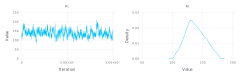

In [17]:
trace_plot(getindex(C, :, "κ₁", :))

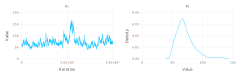

In [18]:
trace_plot(getindex(C, :, "κ₂", :))

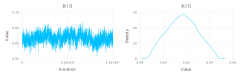

In [19]:
trace_plot(getindex(C, :, "β₁[1]", :))

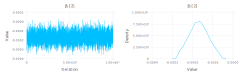

In [20]:
trace_plot(getindex(C, :, "β₁[2]", :))

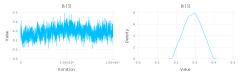

In [21]:
trace_plot(getindex(C, :, "β₂[1]", :))

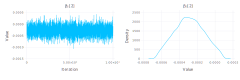

In [22]:
trace_plot(getindex(C, :, "β₂[2]", :))

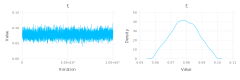

In [23]:
trace_plot(getindex(C, :, "ξ", :))

# 4. Computing a sample of the GEV parameters posterior distribution

Converting the model parameters into the corresponding GEV parameters for the grid cell containing the Montreal-Trudeau airport.

In [24]:
β₁₁ = vec(C[:,"β₁[1]", 1].value)
β₁₂ = vec(C[:,"β₁[2]", 1].value)

β₂₁ = vec(C[:,"β₂[1]", 1].value)
β₂₂ = vec(C[:,"β₂[2]", 1].value)

u = vec(C[:,"u[$ind]", 1].value)
v = vec(C[:,"v[$ind]", 1].value)

ξ = vec(C[:,"ξ", 1].value)

μ = exp.(β₁₁*datastructure.X₁ᵢ[ind, 1] + β₁₂*datastructure.X₁ᵢ[ind, 2] + u)
σ = exp.(β₂₁*datastructure.X₂ᵢ[ind, 1] + β₂₂*datastructure.X₂ᵢ[ind, 2] + v)

10000-element Vector{Float64}:
 10.769232803890153
 11.15147304977692
 11.117227109334536
  9.367086885983728
 10.190563649599987
 10.969718573720167
 12.365704786931767
 12.457028410652232
 11.43892578738885
 12.313123711193569
 10.514495643492591
 10.20017774178878
 10.119837193378602
  ⋮
 11.368292654449368
 12.781999715812004
 11.316299027976118
 10.002223754951125
 10.650054612731822
 11.176983794729773
 12.205341577321066
 11.714400045880941
 11.799063262293465
 11.176919124206238
 11.136521023663304
 11.186469600531987

### Bayesian QQplot between the annual maxima and the spatially fitted GEV distribution 

At the gridcell containing the Montréal Trudeau Airport station.

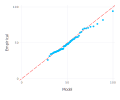

In [25]:
pd = GeneralizedExtremeValue.(μ, σ, ξ)

q, p = Extremes.ecdf(datastructure.Y[ind])

q̂ = Float64[]

for pᵢ in p
    push!(q̂, mean(quantile.(pd, pᵢ)))
end

set_default_plot_size(12cm, 10cm)

plot(x=q̂, y=q, Geom.point, 
    Geom.abline(color="red", style=:dash),
    Guide.xlabel("Model"), Guide.ylabel("Empirical"),
    Theme(discrete_highlight_color=c->nothing))